In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)


In [8]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42, test_size=0.2)
train_labels

14196    1.030
8267     3.821
17445    1.726
14265    0.934
2271     0.965
         ...  
11284    2.292
11964    0.978
5390     2.221
860      2.835
15795    3.250
Name: MedHouseVal, Length: 16512, dtype: float64

In [9]:
lin_reg_pipeline = Pipeline([
  ('standard_scaler', StandardScaler()),
  ('lin_reg', LinearRegression())
])

lin_reg_cv_results = cross_validate(lin_reg_pipeline, train_features,
                                    train_labels, cv=shuffle_split_cv,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=2)
lin_reg_errors = pd.Series(-lin_reg_cv_results['test_score'],
                           name="Linear regression error")


In [10]:
def dummy_regressor_baseline(strategy, const_val=None, quantile_val=None):
  baseline_model_median = DummyRegressor(strategy=strategy,
                                         constant=const_val,
                                         quantile=quantile_val)
  baseline_median_cv_results = cross_validate(baseline_model_median, 
                                              train_features, train_labels, 
                                              cv=shuffle_split_cv,
                                              scoring='neg_mean_absolute_error',
                                              n_jobs=2)
  return pd.Series(-baseline_median_cv_results['test_score'],
                   name='Dummy regressor error')


In [12]:
baseline_median_cv_results_errors = dummy_regressor_baseline(strategy='median')
baseline_mean_cv_serults_erros = dummy_regressor_baseline(strategy='mean')
baseline_constant_cv_results_errors = dummy_regressor_baseline(strategy='constant', 
                                                               const_val=2)
baseline_quantile_cv_results_erros = dummy_regressor_baseline(strategy='quantile', quantile_val=0.55)

In [14]:
dummy_error_df = pd.concat([baseline_mean_cv_serults_erros,
                            baseline_median_cv_results_errors,
                            baseline_quantile_cv_results_erros,
                            baseline_constant_cv_results_errors], axis=1)
dummy_error_df.columns = ['Mean CV', 'Median CV', 'Quantile CV', 'Constant CV']

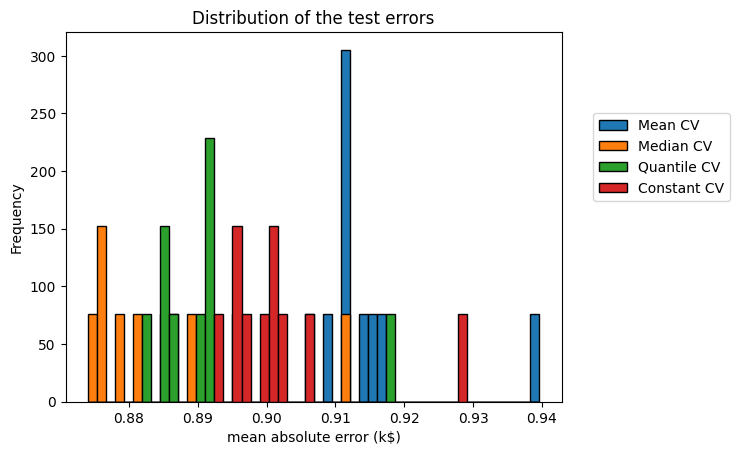

In [17]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.xlabel('mean absolute error (k$)')
_ = plt.title('Distribution of the test errors')

Permutation test score

In [24]:
score, permutation_score, pvalue = permutation_test_score( lin_reg_pipeline,
                                                          train_features, train_labels,
                                                          n_jobs=2, n_permutations=30)
permutation_errors = pd.Series(-permutation_score, name='Permuted error')
print(permutation_score)

[-0.00091607 -0.00063151 -0.000835   -0.00015906 -0.00054229 -0.00060838
 -0.00132363 -0.00147852 -0.00124669 -0.00074707  0.0001039   0.00011561
 -0.00134394 -0.00141796 -0.00094317 -0.00061586 -0.00108025 -0.00056283
 -0.00096096 -0.00091866 -0.00025046 -0.00105601 -0.00151805 -0.00137678
 -0.00123482 -0.0014351  -0.00131133 -0.00078148 -0.00065936 -0.00211526]


In [27]:
error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_errors, permutation_errors],
                     axis=1)


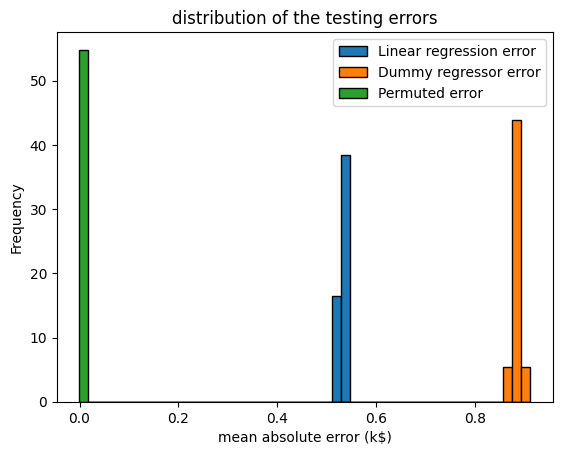

In [28]:
error_df.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(loc='best')
plt.xlabel('mean absolute error (k$)')
_ = plt.title('distribution of the testing errors')